# NB04: Agent Strategies

**Question:** Do iterative_rag and self_rag beat fixed_rag? When? At what cost?

This notebook compares the four agent types:
- `direct_llm` — no retrieval baseline
- `fixed_rag` — single-shot RAG
- `iterative_rag` — multi-iteration with sufficiency checking
- `self_rag` — self-reflective with assessment/verification

Key analyses:
- Per-agent performance with CI
- Agent x Model and Agent x Dataset interactions
- Agent x Retrieval component interactions
- Cost-benefit: does the advanced agent beat the best fixed_rag?

In [8]:
print(1)

1


In [9]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from analysis_utils import (
    load_all_results, setup_plotting, effect_size,
    weighted_mean_with_ci, plot_interaction_heatmap,
    PRIMARY_METRIC, BROKEN_MODELS, MODEL_TIER,
)

setup_plotting()
STUDY_PATH = Path("../outputs/smart_retrieval_slm")

df_all = load_all_results(STUDY_PATH)
df = df_all[~df_all['model_short'].isin(BROKEN_MODELS)].copy()
print(f"Loaded {len(df)} experiments (after removing {BROKEN_MODELS})")
print(f"Agent types: {df['agent_type'].value_counts().to_dict()}")


  343 experiment(s) use configs outside the current YAML.
  Consider adding these to your study config to explore them:
    • model: 42 exps — Phi-3-mini
    • query_transform: 314 exps — iterative
  Deduplicated: dropped 241 duplicate experiments (same effective config, kept best F1)
Loaded 710 experiments (after removing {'Phi-3-mini'})
Agent types: {'iterative_rag': 325, 'self_rag': 191, 'fixed_rag': 152, 'direct_llm': 42}


## 1. Agent Overview

,agent_type,mean,std,ci_low,ci_high,n,min,max
0,fixed_rag,0.2374,0.1756,0.2134,0.2617,152,0.0113,0.6674
1,iterative_rag,0.2372,0.1789,0.2213,0.2553,325,0.0111,0.6743
2,direct_llm,0.2308,0.1769,0.1876,0.2753,42,0.0169,0.6457
3,self_rag,0.2254,0.1744,0.2055,0.2464,191,0.0135,0.6777


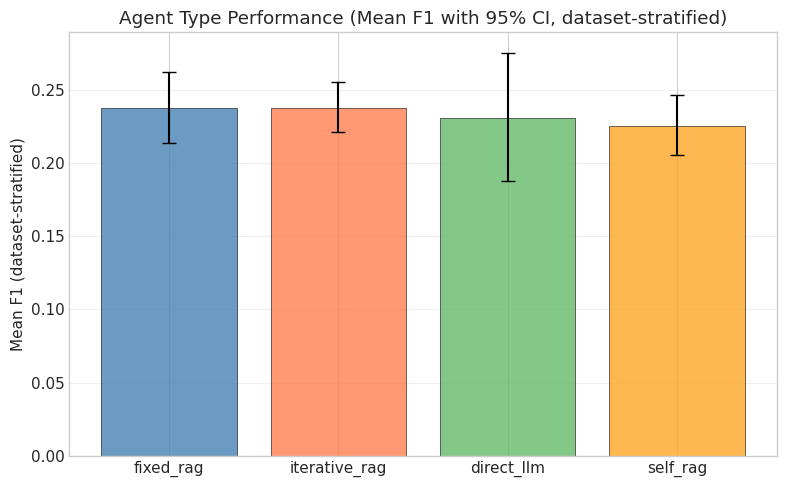


Pairwise effect sizes vs direct_llm (per-dataset, then averaged):
  fixed_rag       : d=+0.063 (negligible, avg of 3 datasets)
  iterative_rag   : d=+0.072 (negligible, avg of 3 datasets)
  self_rag        : d=-0.040 (negligible, avg of 3 datasets)


In [10]:
# weighted_mean_with_ci now uses stratify_by='dataset' by default
agent_stats = weighted_mean_with_ci(df, 'agent_type', PRIMARY_METRIC)
display(agent_stats.round(4))

# Bar chart with CI
fig, ax = plt.subplots(figsize=(8, 5))
x = range(len(agent_stats))
yerr_low = np.maximum(agent_stats['mean'] - agent_stats['ci_low'], 0)
yerr_high = np.maximum(agent_stats['ci_high'] - agent_stats['mean'], 0)
colors = ['steelblue', 'coral', '#66bb6a', '#ffa726'][:len(agent_stats)]
ax.bar(x, agent_stats['mean'], yerr=[yerr_low, yerr_high], capsize=5,
       color=colors, alpha=0.8, edgecolor='black', linewidth=0.5)
ax.set_xticks(x)
ax.set_xticklabels(agent_stats['agent_type'])
ax.set_ylabel('Mean F1 (dataset-stratified)')
ax.set_title('Agent Type Performance (Mean F1 with 95% CI, dataset-stratified)')
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Pairwise effect sizes vs direct — per-dataset then average
datasets = sorted(df['dataset'].unique())
print("\nPairwise effect sizes vs direct_llm (per-dataset, then averaged):")
for agent in ['fixed_rag', 'iterative_rag', 'self_rag']:
    per_ds_d = []
    for ds in datasets:
        direct_vals = df.loc[(df['agent_type'] == 'direct_llm') & (df['dataset'] == ds), PRIMARY_METRIC].dropna().values
        agent_vals = df.loc[(df['agent_type'] == agent) & (df['dataset'] == ds), PRIMARY_METRIC].dropna().values
        if len(agent_vals) >= 2 and len(direct_vals) >= 2:
            d_val, _, _ = effect_size(direct_vals, agent_vals)
            per_ds_d.append(d_val)
    if per_ds_d:
        avg_d = np.mean(per_ds_d)
        interp = 'large' if abs(avg_d) >= 0.8 else 'medium' if abs(avg_d) >= 0.5 else 'small' if abs(avg_d) >= 0.2 else 'negligible'
        print(f"  {agent:<16s}: d={avg_d:+.3f} ({interp}, avg of {len(per_ds_d)} datasets)")

## 2. Agent x Model

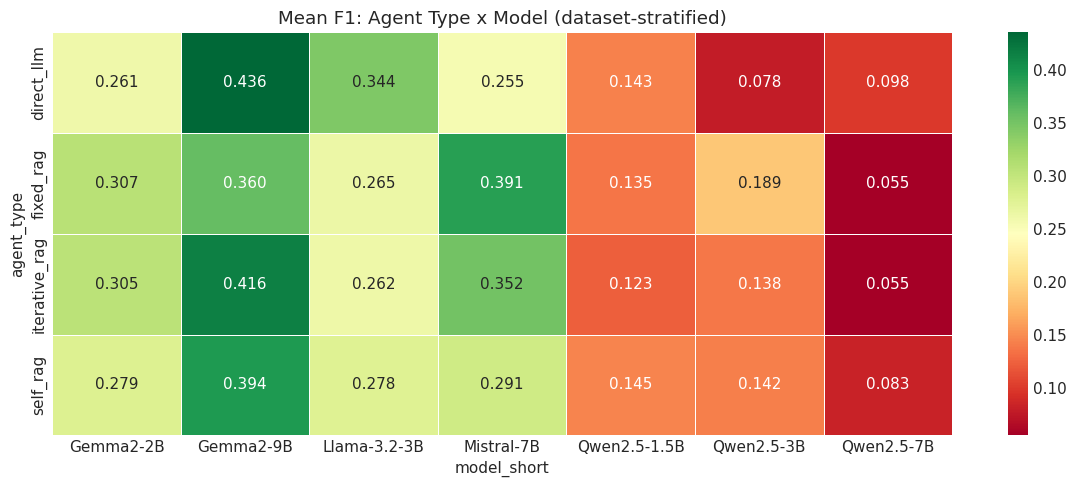

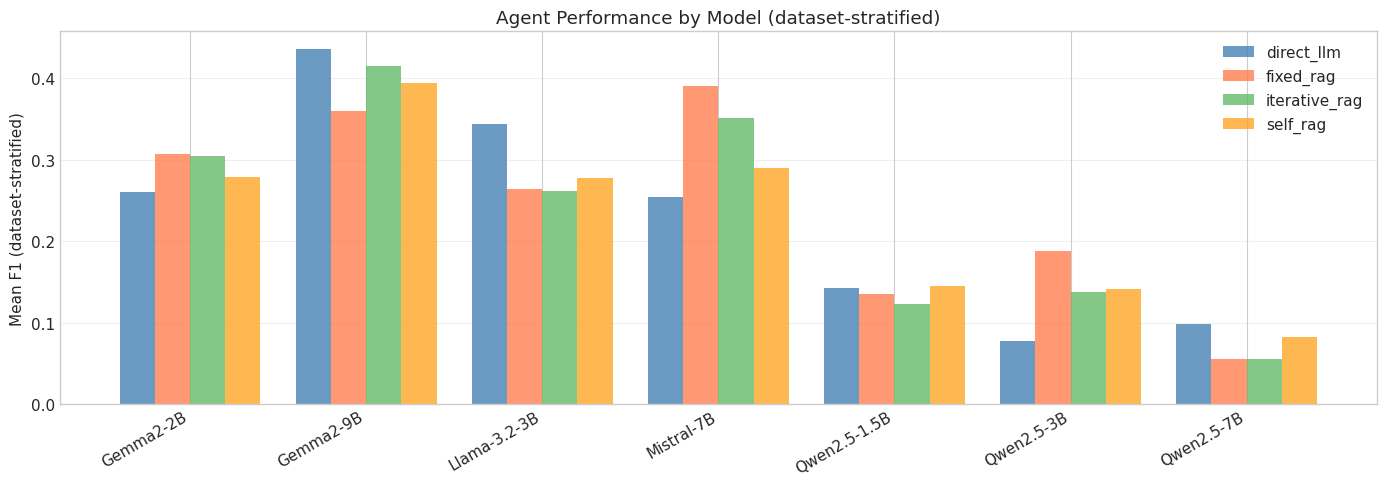

In [11]:
# Heatmap: agent_type x model_short — stratified by dataset
# Per (agent, model, dataset) mean, then average across datasets
per_ds = df.groupby(['agent_type', 'model_short', 'dataset'])[PRIMARY_METRIC].mean()
agent_model = per_ds.groupby(['agent_type', 'model_short']).mean().unstack()

if not agent_model.empty:
    fig, ax = plt.subplots(figsize=(12, 5))
    sns.heatmap(agent_model, annot=True, fmt='.3f', cmap='RdYlGn',
                ax=ax, linewidths=0.5)
    ax.set_title('Mean F1: Agent Type x Model (dataset-stratified)')
    plt.tight_layout()
    plt.show()

    # Also as grouped bars per model
    models = sorted(df['model_short'].unique())
    agents = sorted(df['agent_type'].unique())
    n_agents = len(agents)
    datasets = sorted(df['dataset'].unique())

    fig, ax = plt.subplots(figsize=(14, 5))
    x = np.arange(len(models))
    w = 0.8 / n_agents
    agent_colors = {'direct_llm': 'steelblue', 'fixed_rag': 'coral',
                    'iterative_rag': '#66bb6a', 'self_rag': '#ffa726'}

    for i, agent in enumerate(agents):
        # Stratified mean: per (model, dataset) then average across datasets
        means = []
        for m in models:
            per_ds_vals = [df.loc[(df['model_short'] == m) & (df['agent_type'] == agent) & (df['dataset'] == ds),
                                  PRIMARY_METRIC].mean()
                           for ds in datasets
                           if len(df.loc[(df['model_short'] == m) & (df['agent_type'] == agent) & (df['dataset'] == ds)]) > 0]
            means.append(np.nanmean(per_ds_vals) if per_ds_vals else np.nan)
        ax.bar(x + i * w - (n_agents - 1) * w / 2, means, w,
               label=agent, color=agent_colors.get(agent, f'C{i}'), alpha=0.8)

    ax.set_xticks(x)
    ax.set_xticklabels(models, rotation=30, ha='right')
    ax.set_ylabel('Mean F1 (dataset-stratified)')
    ax.set_title('Agent Performance by Model (dataset-stratified)')
    ax.legend()
    ax.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()

## 3. Agent x Dataset

Key test: does `iterative_rag` help more on multi-hop (HotpotQA)?

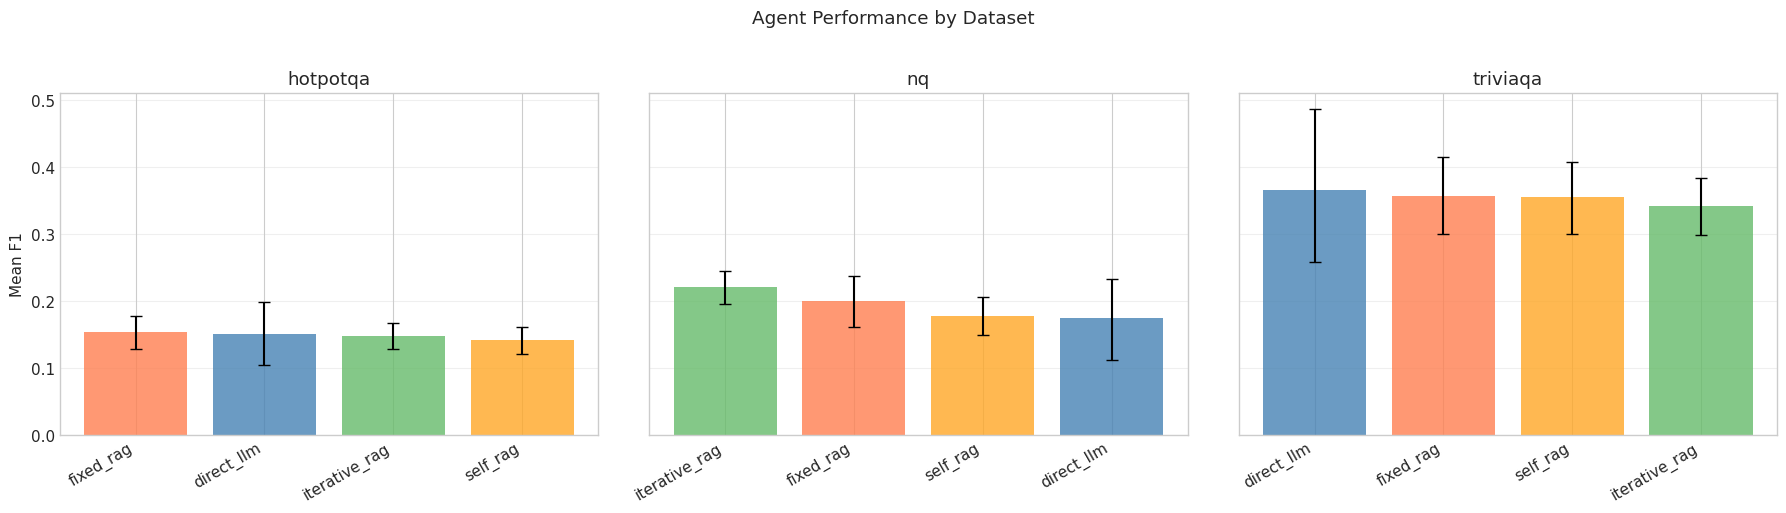


Iterative RAG vs Fixed RAG by dataset:
  hotpotqa    : d=-0.067 (negligible), p=6.91e-01
  nq          : d=+0.159 (negligible), p=3.52e-01
  triviaqa    : d=-0.068 (negligible), p=6.89e-01


In [12]:
datasets = sorted(df['dataset'].unique())
agents = sorted(df['agent_type'].unique())

fig, axes = plt.subplots(1, len(datasets), figsize=(6 * len(datasets), 5), sharey=True)
if len(datasets) == 1:
    axes = [axes]

agent_colors = {'direct_llm': 'steelblue', 'fixed_rag': 'coral',
                'iterative_rag': '#66bb6a', 'self_rag': '#ffa726'}

for ax, ds in zip(axes, datasets):
    ds_df = df[df['dataset'] == ds]
    stats = weighted_mean_with_ci(ds_df, 'agent_type', PRIMARY_METRIC)
    if stats.empty:
        continue

    x = range(len(stats))
    yerr_low = np.maximum(stats['mean'] - stats['ci_low'], 0)
    yerr_high = np.maximum(stats['ci_high'] - stats['mean'], 0)
    colors = [agent_colors.get(a, 'grey') for a in stats['agent_type']]
    ax.bar(x, stats['mean'], yerr=[yerr_low, yerr_high], capsize=4,
           color=colors, alpha=0.8)
    ax.set_xticks(x)
    ax.set_xticklabels(stats['agent_type'], rotation=30, ha='right')
    ax.set_title(ds)
    ax.set_ylabel('Mean F1' if ax == axes[0] else '')
    ax.grid(axis='y', alpha=0.3)

plt.suptitle('Agent Performance by Dataset', y=1.02)
plt.tight_layout()
plt.show()

# Print per-dataset effect sizes: iterative_rag vs fixed_rag
print("\nIterative RAG vs Fixed RAG by dataset:")
for ds in datasets:
    fixed = df.loc[(df['agent_type'] == 'fixed_rag') & (df['dataset'] == ds), PRIMARY_METRIC].dropna().values
    iterative = df.loc[(df['agent_type'] == 'iterative_rag') & (df['dataset'] == ds), PRIMARY_METRIC].dropna().values
    if len(fixed) >= 2 and len(iterative) >= 2:
        d, pval, interp = effect_size(fixed, iterative)
        print(f"  {ds:<12s}: d={d:+.3f} ({interp}), p={pval:.2e}")
    else:
        print(f"  {ds:<12s}: insufficient data")

## 4. Agent x Retrieval Components

Is `self_rag + reranker` synergistic or redundant? Does agent type interact with retriever type?

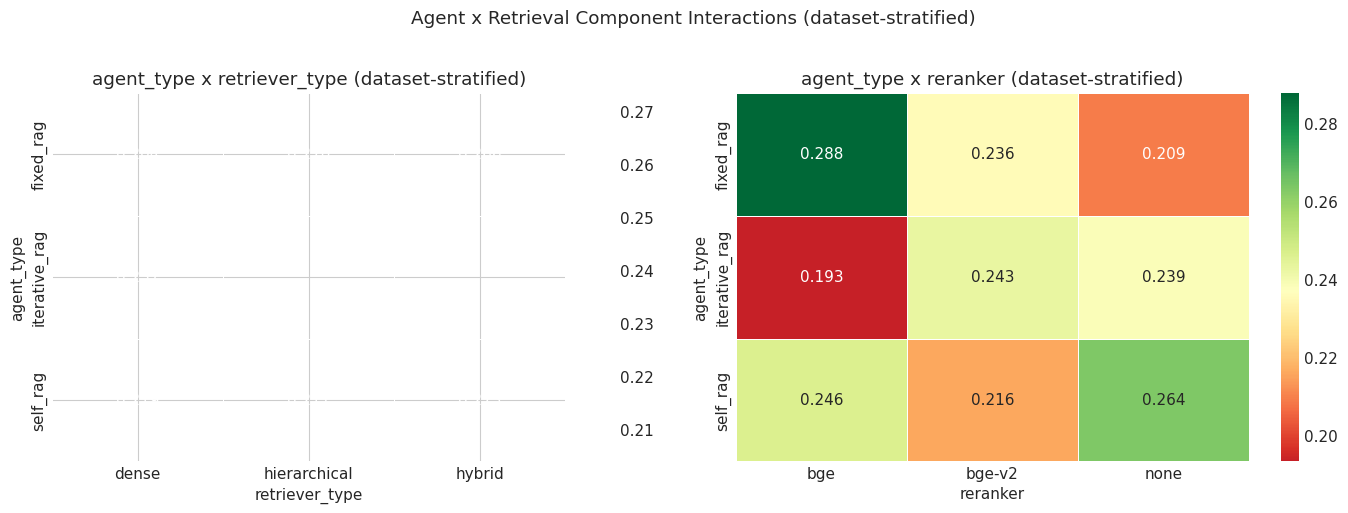

In [13]:
rag_df = df[df['exp_type'] == 'rag'].copy()

interaction_pairs = [
    ('agent_type', 'retriever_type'),
    ('agent_type', 'reranker'),
]
interaction_pairs = [(f1, f2) for f1, f2 in interaction_pairs
                     if f1 in rag_df.columns and f2 in rag_df.columns
                     and rag_df[f1].nunique() > 1 and rag_df[f2].nunique() > 1]

if interaction_pairs:
    fig, axes = plt.subplots(1, len(interaction_pairs),
                             figsize=(7 * len(interaction_pairs), 5))
    if len(interaction_pairs) == 1:
        axes = [axes]

    for ax, (f1, f2) in zip(axes, interaction_pairs):
        # Stratified: per (f1, f2, dataset) mean, then average across datasets
        per_ds = rag_df.groupby([f1, f2, 'dataset'])[PRIMARY_METRIC].mean()
        pivot = per_ds.groupby([f1, f2]).mean().unstack()
        if not pivot.empty:
            sns.heatmap(pivot, annot=True, fmt='.3f', cmap='RdYlGn',
                        center=pivot.values.mean(), ax=ax, linewidths=0.5)
            ax.set_title(f'{f1} x {f2} (dataset-stratified)')

    plt.suptitle('Agent x Retrieval Component Interactions (dataset-stratified)', y=1.02)
    plt.tight_layout()
    plt.show()
else:
    print("Not enough factor pairs for interaction analysis.")

## 5. Cost-Benefit: Advanced Agents vs Best Fixed RAG

In [14]:
# For each model+dataset, compare best fixed_rag vs best advanced agent
group_cols = ['model_short', 'dataset']
results = []

for group_vals, group_df in rag_df.groupby(group_cols):
    model, dataset = group_vals
    fixed = group_df[group_df['agent_type'] == 'fixed_rag']
    advanced = group_df[group_df['agent_type'].isin(['iterative_rag', 'self_rag'])]

    if fixed[PRIMARY_METRIC].notna().sum() == 0 or advanced[PRIMARY_METRIC].notna().sum() == 0:
        continue

    best_fixed = fixed[PRIMARY_METRIC].max()
    best_advanced = advanced[PRIMARY_METRIC].max()
    best_agent = advanced.loc[advanced[PRIMARY_METRIC].idxmax(), 'agent_type']

    results.append({
        'model': model, 'dataset': dataset,
        'best_fixed_rag': best_fixed,
        'best_advanced': best_advanced,
        'best_agent': best_agent,
        'delta': best_advanced - best_fixed,
        'advanced_wins': best_advanced > best_fixed,
    })

cost_df = pd.DataFrame(results)
if not cost_df.empty:
    n_wins = cost_df['advanced_wins'].sum()
    n_total = len(cost_df)
    print(f"Advanced agent beats best fixed_rag in {n_wins}/{n_total} "
          f"({n_wins/n_total*100:.0f}%) of model+dataset scenarios")
    print(f"Mean delta when wins: {cost_df.loc[cost_df['advanced_wins'], 'delta'].mean():.4f}")
    print(f"Mean delta when loses: {cost_df.loc[~cost_df['advanced_wins'], 'delta'].mean():.4f}")
    print()
    display(cost_df.round(4))
else:
    print("Not enough data for cost-benefit analysis.")

Advanced agent beats best fixed_rag in 18/21 (86%) of model+dataset scenarios
Mean delta when wins: 0.0276
Mean delta when loses: -0.0421



,model,dataset,best_fixed_rag,best_advanced,best_agent,delta,advanced_wins
0,Gemma2-2B,hotpotqa,0.2336,0.2530,iterative_rag,0.0193,True
1,Gemma2-2B,nq,0.3268,0.3483,iterative_rag,0.0215,True
2,Gemma2-2B,triviaqa,0.5704,0.5713,iterative_rag,0.0009,True
3,Gemma2-9B,hotpotqa,0.2748,0.3305,iterative_rag,0.0557,True
4,Gemma2-9B,nq,0.4011,0.4283,iterative_rag,0.0272,True
5,Gemma2-9B,triviaqa,0.6674,0.6777,self_rag,0.0103,True
6,Llama-3.2-3B,hotpotqa,0.2246,0.2355,iterative_rag,0.0108,True
7,Llama-3.2-3B,nq,0.3408,0.3670,iterative_rag,0.0262,True
8,Llama-3.2-3B,triviaqa,0.5750,0.5989,self_rag,0.0239,True
9,Mistral-7B,hotpotqa,0.2999,0.3053,iterative_rag,0.0054,True


## 6. Summary

Key takeaways:
- Which agent type performs best overall
- Whether iterative_rag helps on multi-hop datasets
- Whether self_rag + reranker is synergistic or redundant
- % of scenarios where advanced agents justify their complexity